# Deep NLP

For this last class, we are going to try to build the neural network equivalents of the NLP models we built in week 4 of the course, and extend our understanding of how to build NLP models by utilizing contextual information from our corpuses.

For the class, we will introduce two additional NLP libraries:

- [spaCy](https://spacy.io/): Industrial-grade NLP library for building NLP pipelines over large corpora.
- [gensim](https://radimrehurek.com/gensim/index.html): A library that allows us to generate our own word vector embeddings

Use the following code to install the libraries we will need for this class:

```
conda install -c anaconda gensim
conda install -c conda-forge spacy
```

You also need to download a `spaCy` model that we can use as part of our explorations. 
In order to do so, run the following from a terminal window:

```
python3 -m spacy download en
```

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import base64
import string #use for punctuation removal
import re
from collections import Counter
from time import time

#nlp specific libraries
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
nlp = spacy.load('en')
#nlp = spacy.load('en_core_web_lg')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Generating a smaller document set

Using Deep Neural Networks is **incredibly computationally expensive.** So, we are not going to train these networks on all of the data, so I have generated a smaller dataset using only 20K yelp reviews.

Our goal will be to simply compare a couple of different strategies for creating features from text, feeding them to either a multilayer perceptron (MLP) or a fairly deep convolutional neural net, and seeing the results. I'll explain each of these types of networks in turn.

We will also attempt 2 distinct strategies on the data we have:

1. Compute our own word vector representations on lightly preprocessed versions of the reviews.
2. Use precomputed word vector representations on lightly preprocessed versions of the reviews.


As we explore each strategy, we will get a feel for some of the limitations of both, and some overall strategies for  feature engineering our data.

In [4]:
yelp = pd.read_csv("yelp_smaller_20k.csv",index_col=0).reset_index(drop=True)
yelp.head()

,business_id,stars,text,user_id
0,8Gi91EkhG2_CJLk_WqjpEg,1,I found them through Craigslist. I did the 2 m...,um0ITBTHoohdozmFA6snlw
1,6zincCvQTb9BsuK-GHZ4cw,5,"Great pizza, excellent delivery time & if I ev...",tNcIhWEeAl607ENbeRSm0w
2,kzANsUYAZFnMsogB1RFE7A,5,Finding an incredible hairstylist is like find...,EJ7ZhRHsMWj8du77LX34gw
3,uBAHE6QOJlndILPIoeEpCQ,1,I attempted to use a coupon for the exact item...,RNVCLdKNddXp8v-y6Aq2Xg
4,yzmvsG3Vo-2_F3_0wHzJdA,1,Dammit! I had such high hopes for this place. ...,D5ETbJC0dptWR07sbTlqRg


In [5]:
print(yelp.stars.value_counts()/yelp.shape[0])
print(yelp.stars.value_counts())

5    0.7537
1    0.2463
Name: stars, dtype: float64
5    15074
1     4926
Name: stars, dtype: int64


In [6]:
yelp["target"] = (yelp.stars == 5).astype(int)

## An overview of frequency embeddings

Last week, we used `CountVectorizer` and `TFIDFVectorizer` to generate features from our texts. 

Both of the above feature engineering strategies are a kind of **embedding** of the text. 

**An embedding in mathematics is a projection of some data into some other fixed space.**

In the case of the 2 above strategies, we are creating what are called **frequency-based embeddings** where we **embed** each individual variable-length text into a fixed-length vector (whose size is the number of distinct tokens we are using).

So, we are completely ignoring the context (words surrounding each word) and simply creating a mapping of texts onto token frequency within that text.

## Context-based Embeddings

**However, there are other ways to generate embeddings!** 

One simple way to do this is to **create word co-occurrence matrices with some (usually fixed) context window**.

What this means is you can simply count the frequency that a given word appears next to some other word, where *next to* is defined by the context window size (how many tokens away the context word is allowed to be in order to be considered part of the given word's context).

E.g.:

In the sentence **My name is Sergey and my home is in Brooklyn.** The co-occurrence value of the terms (Sergey,home) with a context window of 3 is 1, but would be 0 if the context window were 2.

**Now, after we have computed all of our cooccurrence counts, we transform each of our texts into some aggregate of all of the cooccurrence pairs that exist for that text (usually either taking the sum or the average of all cooccurrence contexts).**

However, there is a **huge** problem with this approach:
- This yields massive cooccurrence matrix. It will be expensive to store (the number of distinct word/context pairs grows very quickly in the size of the vocabulary of the corpus).
- This massive matrix is also incredibly sparse. Again, having massive, sparse spaces is very bad for machine learning.

So, we need some way to shrink the size of this matrix. One way is to simply SVD or PCA it into some smaller size. This actually works reasonably well, but we can do even better...

## Context-based Embeddings: Neural-Network based Predictive Embeddings

Now, let's go just a bit further. 

Instead of attempting to deterministically use the co-occurrence statistics of some text, which is a very high-dimensional representation of the corpus, we can try to create a model that predicts the most likely context given a specific word (or the most likely word given some context). 

The idea here is to learn some fixed-dimensional representation of the probability distribution of words given their contexts (**CBOW Word2Vec**) or contexts given a word (**skip-gram Word2Vec**).

**In both cases, what we are actually doing is training a shallow (single hidden layer) neural network over our corpus of co-occurrence statistics and extracting the weights of the learned hidden layer after training.**

So, the result of a word2vec training is generating a fixed-element distributed representation of each distinct word in the vocabulary defined over the corpus.

Once we have such a representation, we can do interesting things with it like:

- Find most similar words (since this is a vector, we simply compute the cosine similarity)
- Word math (this is the famous $king - man + woman = queen$) example
- Odd one out (given a list of words, which is least like the others)

We can also then use these new word representations as inputs into ML pipelines (either simple models or deep neural nets, as we will see below).

## CBOW Word2Vec Architecture


In the case where we are trying to predict the most likely word given some context.

That is, we are trying to **maximize the probability of the target word by looking at the context.** 

Single word context (what is the most likely word given the word "really"?):
![word2vec](./images/word2vec_network.png)

Multiple Word Context, predicting most likely word (what is the most likely word in the context "Today is the last ... of the session"?):
![word2vec2](./images/word2vec_network_2.png)


In both of these cases, we will have a problem for rare words because the model is designed to predict the most probable word. Whatever this word is, it will be smoothed over a lot of examples with more frequent words.

## Skip-gram Word2Vec Architecture

In this case, we can turn the problem on its head, predicting the most likely context given some word.
![word2vec3](./images/word2vec_network_3.png)

Because the skip-gram model is designed to predict the context (rather than the most likely word), rare words do not compete with more frequent words.


Ultimately, both of these models have tradeoffs:
- **CBOW**: Very fast training (much faster than skip-gram), very good representation of the most frequent words in your vocabulary.
- **Skip-gram**: Slower to train, but preferred with a small amount of the training data, represents rare words or phrases well.




## Other Embedding Architectures

- Doc2Vec
- Sense2Vec
- GloVe - word2vec ultimately loses the statistical properties of corpus (cooccurrence statistics are not kept, since word2vec turns this into a prediction problem). GloVe factorizes the cooccurrence matrix in an interesting way (sort of like PCA/SVD) and can sometimes lead to better embeddings.

## Train your own word2vec model on yelp data

The process will be as follows:
- We need to generate lists of sentences across the entire corpus. It doesnt matter what document each sentence comes from. 
- We will lemmatize individual words, and split entire documents into sentences as below.
- Following preprocessing, we train word2vec on the entire corpus.

In [8]:
# Define function to preprocess text for a word2vec model
def cleanup_text_word2vec(docs, logging=False):
    sentences = []
    counter = 1
    for doc in nlp.pipe(docs,n_threads=4,disable=["tagger"]):
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(docs)))
        # Grab lemmatized form of words and make lowercase
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # Split into sentences based on punctuation - assuming a period, question mark, exclamation point, and apostroper
        # dictate the end of a given sentence.
        doc = re.split("[\.?!;] ", doc)
        # Remove commas, periods, and other punctuation (mostly commas) from each sentence
        doc = [re.sub("[\.,;:!?]", "", sent) for sent in doc]
        # Split each sentence into distinct words
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
    return sentences

In [9]:
yelp_cleaned_word2vec = cleanup_text_word2vec(yelp.text, logging=True)

Processed 1000 out of 20000 documents
Processed 2000 out of 20000 documents
Processed 3000 out of 20000 documents
Processed 4000 out of 20000 documents
Processed 5000 out of 20000 documents
Processed 6000 out of 20000 documents
Processed 7000 out of 20000 documents
Processed 8000 out of 20000 documents
Processed 9000 out of 20000 documents
Processed 10000 out of 20000 documents
Processed 11000 out of 20000 documents
Processed 12000 out of 20000 documents
Processed 13000 out of 20000 documents
Processed 14000 out of 20000 documents
Processed 15000 out of 20000 documents
Processed 16000 out of 20000 documents
Processed 17000 out of 20000 documents
Processed 18000 out of 20000 documents
Processed 19000 out of 20000 documents
Processed 20000 out of 20000 documents


At this point, we just have a list of lists, where each sublist is a sentence, and each token in that sentence is a word. We have now lost all of the information regarding what reviews each sentence originally belonged to (we will need this information later).


Here are the first 5 processed sentences in our corpus:

In [10]:
print(yelp_cleaned_word2vec[:8])

[['i', 'find', 'them', 'through', 'craigslist'], ['i', 'do', 'the', '2', 'maid', 'for', '68', 'dollar', 'for', 'two', 'hour'], ['first', 'thing', 'be', 'they', 'be', 'pretty', 'late', 'about', '30', 'minute', 'late'], ['but', 'i', 'be', 'understand', 'a', 'i', 'do', 'live', 'in', 'a', 'far', 'fling', 'area', 'of', 'the', 'valley'], ['they', 'do', 'speak', 'very', 'little', 'english', 'and', 'i', 'speak', 'a', 'little', 'spanish', 'but', 'we', 'be', 'able', 'to', 'communicate', 'good', 'enough']]


### Using [gensim](https://radimrehurek.com/gensim/models/word2vec.html) to build word2vec model

In [11]:
from gensim.models.word2vec import Word2Vec

text_dim = 300
print("Training Word2Vec model...")
wordvec_model_300 = Word2Vec(yelp_cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)
print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model_300.wv.vocab), text_dim))

Training Word2Vec model...
Word2Vec model created.
13855 unique words represented by 300 dimensional vectors


Lets test to see if the model is making reasonable embeddings:

In [13]:
print("Words most similar to breakfast:\n",wordvec_model_300.wv.most_similar(positive=['breakfast']))
print()
print("Words most similar to breakfast minus lunch:\n",wordvec_model_300.wv.most_similar_cosmul(positive=['breakfast'], negative=["lunch"]))
print()
print("Which of the words breakfast stupid dinner lunch don\'t match: ",wordvec_model_300.wv.doesnt_match("breakfast stupid dinner lunch".split()))
print()
print("How related is breakfast to brunch: ",wordvec_model_300.wv.similarity('breakfast', 'brunch'))
print()
print("How related is breakfast to dinner: ",wordvec_model_300.wv.similarity('breakfast', 'dinner'))

Words most similar to breakfast:
 [('brunch', 0.7401005029678345), ('lunch', 0.7071179151535034), ('continental', 0.6997714042663574), ('takeout', 0.6910825371742249), ('hangover', 0.6854385137557983), ('bagel', 0.6732635498046875), ('burrito', 0.6707483530044556), ('nachos', 0.6685673594474792), ('omelet', 0.663787841796875), ('cheeseburger', 0.6620101928710938)]

Words most similar to breakfast minus lunch:
 [('chocolate', 1.1713966131210327), ('cream', 1.168455719947815), ('apple', 1.1631273031234741), ('vanilla', 1.160402536392212), ('donut', 1.1572304964065552), ('ice', 1.155745506286621), ('banana', 1.1552790403366089), ('custard', 1.1518254280090332), ('muffin', 1.1508272886276245), ('bake', 1.1500821113586426)]

Which of the words breakfast stupid dinner lunch don't match:  stupid

How related is breakfast to brunch:  0.7401005582820208

How related is breakfast to dinner:  0.6201278397580494


All of this looks good! Looks like our learned word embeddings pass the initial smell test!

## TODO: Alter the size of the embedding dimension. How does this change word similarities?

In [102]:
text_dim = 100
print("Training Word2Vec model...")
wordvec_model = Word2Vec(yelp_cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)
print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))

Training Word2Vec model...
Word2Vec model created.
13855 unique words represented by 100 dimensional vectors


In [103]:
print("Words most similar to breakfast:\n",wordvec_model.wv.most_similar(positive=['breakfast']))
print()
print("Words most similar to breakfast minus lunch:\n",wordvec_model.wv.most_similar_cosmul(positive=['breakfast'], negative=["lunch"]))
print()
print("Which of the words breakfast stupid dinner lunch don\'t match: ",wordvec_model.wv.doesnt_match("breakfast stupid dinner lunch".split()))
print()
print("How related is breakfast to brunch: ",wordvec_model.wv.similarity('breakfast', 'brunch'))
print()
print("How related is breakfast to dinner: ",wordvec_model.wv.similarity('breakfast', 'dinner'))

Words most similar to breakfast:
 [('lunch', 0.7887130975723267), ('brunch', 0.7867841124534607), ('hangover', 0.7359310388565063), ('baklava', 0.7228267788887024), ('bagel', 0.7200120687484741), ('continental', 0.7187748551368713), ('omelet', 0.7150955200195312), ('shawarma', 0.7141053676605225), ('cheesesteak', 0.7123523354530334), ('gyros', 0.7100532054901123)]

Words most similar to breakfast minus lunch:
 [('cream', 1.201401948928833), ('chocolate', 1.1742335557937622), ('muffin', 1.173460602760315), ('ice', 1.1727256774902344), ('vanilla', 1.1705455780029297), ('apple', 1.169739842414856), ('donut', 1.169620156288147), ('custard', 1.167542815208435), ('creme', 1.162365436553955), ('divine', 1.1607450246810913)]

Which of the words breakfast stupid dinner lunch don't match:  stupid

How related is breakfast to brunch:  0.7867841170428731

How related is breakfast to dinner:  0.687764313389204


How can we now use these embeddings for our original purpose (document classification)?

One way is to reprocess our text into strings of words, generate each word's embedding, and average across all embeddings.

So, let's create a function that given some document (yelp review), computes the word-embedding average across the entire document:

In [59]:
# Define function to create word vectors given a cleaned piece of text.
def create_average_vec(doc):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    doc = doc.split(" ")
    for word in doc:
        if word in wordvec_model_300.wv.vocab:
            average = np.add(average, wordvec_model_300[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [58]:
type(0.0) == float

True

However, now we have a problem. Our original data we trained word2vec on was a list of lists where we lost the indices of each sentence. What we will need to do is reprocess our original yelp review dataset in such a way that we can actually keep all of the indices of the original documents. That is, strip all of the sentence information, but keep the tokens from each sentence.

In [20]:
# Define function to cleanup text by removing stopwords, and punctuation
punctuations = string.punctuation

def cleanup_text(docs, logging=True):
    proc_docs = []
    counter = 1
    for doc in nlp.pipe(docs, n_threads=4,disable=["tagger"]):
        if counter % 200 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        tokens = [tok.lemma_.lower().strip() for tok in doc] #lemmatize, remove pronouns #if tok.lemma_ != '-PRON-'
        tokens = [tok for tok in tokens if tok not in stopwords.words() and tok not in punctuations] #remove stopwords, punctuation
        tokens = ' '.join(tokens)
        proc_docs.append(tokens)
    return proc_docs

In [21]:
cleaned_yelp_text = cleanup_text(yelp.text, logging=True)

Processed 200 out of 20000 documents.
Processed 400 out of 20000 documents.
Processed 600 out of 20000 documents.
Processed 800 out of 20000 documents.
Processed 1000 out of 20000 documents.
Processed 1200 out of 20000 documents.
Processed 1400 out of 20000 documents.
Processed 1600 out of 20000 documents.
Processed 1800 out of 20000 documents.
Processed 2000 out of 20000 documents.
Processed 2200 out of 20000 documents.
Processed 2400 out of 20000 documents.
Processed 2600 out of 20000 documents.
Processed 2800 out of 20000 documents.
Processed 3000 out of 20000 documents.
Processed 3200 out of 20000 documents.
Processed 3400 out of 20000 documents.
Processed 3600 out of 20000 documents.
Processed 3800 out of 20000 documents.
Processed 4000 out of 20000 documents.
Processed 4200 out of 20000 documents.
Processed 4400 out of 20000 documents.
Processed 4600 out of 20000 documents.
Processed 4800 out of 20000 documents.
Processed 5000 out of 20000 documents.
Processed 5200 out of 20000 d

In [144]:
# Clean up all text DO NOT RUN THIS AS IT TAKES SOME TIME

#yelp_smaller_clean = pd.Series(cleanup_text(yelp.text,logging=True))

# LOAD IN THE CLEANED DATA INSTEAD :)
yelp_smaller_clean = pd.read_csv("./yelp_cleaned_word2vec.csv")
yelp_smaller_clean.head()
yelp_smaller_clean.cleaned_text.fillna("",inplace=True)

,cleaned_text,text,stars,target
0,find craigslist 2 maid 68 dollar two hour firs...,I found them through Craigslist. I did the 2 m...,1,0
1,great pizza excellent delivery time ever back ...,"Great pizza, excellent delivery time & if I ev...",5,1
2,finding incredible hairstylist like find unico...,Finding an incredible hairstylist is like find...,5,1
3,attempt use coupon exact item state picture ma...,I attempted to use a coupon for the exact item...,1,0
4,dammit high hope place -pron- eat month finall...,Dammit! I had such high hopes for this place. ...,1,0


In [60]:
final_cleaned_vec = np.zeros((yelp_smaller_clean.shape[0], text_dim), dtype="float32")  # 20000 x 300
for i in range(yelp_smaller_clean.shape[0]):
    final_cleaned_vec[i] = create_average_vec(yelp_smaller_clean.cleaned_text.values[i])

print("Final word vector shape:", final_cleaned_vec.shape)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Final word vector shape: (20000, 300)


Here's an example final vector:

In [71]:
final_cleaned_vec[20]

array([ 3.60599495e-02, -9.28331073e-03, -7.08896071e-02,  9.19171795e-02,
       -1.51448678e-02,  2.50284635e-02, -4.37611751e-02, -2.09709466e-01,
       -9.79925040e-03, -3.84979583e-02, -3.33492197e-02,  1.14552528e-01,
       -9.56085026e-02, -9.21426564e-02, -8.17813072e-03, -7.64578879e-02,
       -8.61215591e-02, -2.57790629e-02, -9.30847134e-04,  9.52796042e-02,
       -9.62017030e-02, -1.49020776e-01,  3.18391211e-02,  6.60932809e-02,
        7.78950527e-02,  7.99593404e-02,  1.00615986e-01,  9.32607520e-03,
        5.69754541e-02, -1.33204699e-01,  1.00597061e-01,  2.56251507e-02,
        8.77018198e-02,  7.47963861e-02,  2.07077786e-02, -1.38422996e-01,
       -1.30761519e-01,  3.90914716e-02, -6.33014888e-02,  1.71119139e-01,
        1.35665447e-01,  1.39350057e-01, -9.13011804e-02, -3.83911058e-02,
       -3.56462896e-02, -4.05536927e-02,  1.81750163e-01, -9.79515016e-02,
        7.81220421e-02, -4.41372804e-02, -8.22386816e-02, -1.08498238e-01,
        1.51756117e-02,  

Let's see what a linear model can do with this data:

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,StratifiedKFold

In [78]:
sk = StratifiedKFold(n_splits=10)
np.mean(cross_val_score(LogisticRegression(),
                        final_cleaned_vec,
                        yelp_smaller_clean.target,
                        cv=sk,
                        scoring="accuracy"))

0.9470498394749599

And a nonlinear model:

In [80]:
from sklearn.ensemble import RandomForestClassifier

sk = StratifiedKFold(n_splits=3)
np.mean(cross_val_score(RandomForestClassifier(n_estimators=50),
                        final_cleaned_vec,
                        yelp_smaller_clean.target,
                        cv=sk,
                        scoring="accuracy"))

0.9262499596292312

Now lets split our data and train a new keras model:

In [88]:
from sklearn.model_selection import train_test_split

#using spaCy word vectors
X_train, X_test, y_train, y_test = train_test_split(final_cleaned_vec, yelp_smaller_clean.target, test_size=0.2, random_state=21)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))
print("y-split train:\n",y_train.value_counts()/y_train.shape[0])
print("y-split test:\n",y_test.value_counts()/y_test.shape[0])

X_train size: (16000, 300)
X_test size: (4000, 300)
y_train size: (16000,)
y_test size: (4000,)
y-split train:
 1    0.75575
0    0.24425
Name: target, dtype: float64
y-split test:
 1    0.7455
0    0.2545
Name: target, dtype: float64


In [133]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD

def build_model(architecture='mlp',input_dim=300):
    model = Sequential()
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
    elif architecture == 'cnn':
        # 1-D Convolutional Neural Network - you can create a neural network this way as well
        inputs = Input(shape=(input_dim,1))

        x = Conv1D(64, 3, strides=1, padding='same', kernel_initializer="uniform",activation='relu')(inputs)

        #Cuts the size of the output in half, maxing over every 2 inputs
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(128, 3, strides=1, padding='same', kernel_initializer="uniform",activation='relu')(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(1, kernel_initializer="uniform", activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs, name='CNN')
    else:
        print('Error: Model type not found.')
    return model

In [90]:
# Define keras model
# Using MLP in kernel for speed
#model = build_model('mlp')
model = build_model('cnn')

# If the model is a CNN then expand the dimensions of the training data
if model.name == "CNN":
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    print('Text train shape: ', X_train.shape)
    print('Text test shape: ', X_test.shape)
    
model.summary()


Text train shape:  (16000, 300, 1)
Text test shape:  (4000, 300, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 300, 64)           256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 150, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 150, 128)          24704     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 25,089
Trainable params: 25,089
Non-trainable params: 0
____

In [94]:
# Compile the model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['acc'])

In [95]:
# Define number of epochs
epochs = 10

# Fit the model to the training data
estimator = model.fit(X_train, y_train,
                      validation_data=(X_test,y_test),
                      epochs=epochs, batch_size=128, verbose=1)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 17s 1ms/step - loss: 0.5464 - acc: 0.7558 - val_loss: 0.5215 - val_acc: 0.7455
Epoch 2/10
16000/16000 [==============================] - 16s 1ms/step - loss: 0.4104 - acc: 0.8032 - val_loss: 0.3346 - val_acc: 0.8678
Epoch 3/10
16000/16000 [==============================] - 16s 1ms/step - loss: 0.2932 - acc: 0.8774 - val_loss: 0.2766 - val_acc: 0.8885
Epoch 4/10
16000/16000 [==============================] - 16s 1ms/step - loss: 0.2518 - acc: 0.8970 - val_loss: 0.2480 - val_acc: 0.8988
Epoch 5/10
16000/16000 [==============================] - 16s 1ms/step - loss: 0.2316 - acc: 0.9055 - val_loss: 0.2310 - val_acc: 0.9048
Epoch 6/10
16000/16000 [==============================] - 16s 1ms/step - loss: 0.2187 - acc: 0.9107 - val_loss: 0.2202 - val_acc: 0.9070
Epoch 7/10
16000/16000 [==============================] - 17s 1ms/step - loss: 0.2079 - acc: 0.9162 - val_loss: 0.2129 - val_acc:

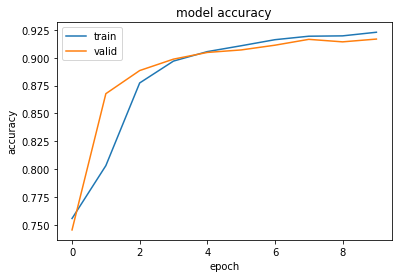

In [96]:
# Plot model accuracy over epochs
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## TODO

1. Try the `mlp` model. Does it give similar performance? Is it faster?
2. Try to create a neural network model that outperforms the Logistic Regression model we just built.

In [ ]:
pass

## Use precomputed spaCy vectors

Here, we will attempt to use the vector-space representations of words (word embeddings) that have already been pre-created for us. Since word vectors occur on a per-word basis, and each of our documents is a collection of words, the typical strategy is to generate a word vector representation for each word in the given document (review) and average across all found word vectors. This is also exactly what `spaCy` does by default.

## Clean up text using spaCy

In [50]:
# Clean text before feeding it to spaCy
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and punctuation
def cleanup_text(docs, logging=True):
    proc_docs = []
    counter = 1
    for doc in nlp.pipe(docs, n_threads=4,disable=['parser', 'ner']):
        if counter % 200 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-'] #lemmatize, remove pronouns
        tokens = [tok for tok in tokens if tok not in stopwords.words() and tok not in punctuations] #remove stopwords, punctuation
        tokens = ' '.join(tokens)
        proc_docs.append(tokens)

The code above does the following:
- tokenize on spaces
- lowercase every token
- lemmatization (find root word for each word in text)
- remove stopwords and punctuation

This is a fairly involved process and takes some time (this took >10 minutes on my machine). Instead of you having to do this, I've already cleaned the text for you using the function above.

In [97]:
# Clean up all text DO NOT RUN THIS AS IT TAKES SOME TIME

#yelp_smaller_clean = pd.Series(cleanup_text(yelp.text,logging=True))

# LOAD IN THE CLEANED DATA INSTEAD :)
yelp_smaller_spacy = pd.read_csv("./yelp_smaller_cleaned_spacy.csv")
yelp_smaller_spacy.head()

,text,cleaned_text,stars,target
0,I found them through Craigslist. I did the 2 m...,find craigslist 2 maid 68 dollar two hour firs...,1,0
1,"Great pizza, excellent delivery time & if I ev...",great pizza excellent delivery time ever back ...,5,1
2,Finding an incredible hairstylist is like find...,find incredible hairstylist like find unicorn ...,5,1
3,I attempted to use a coupon for the exact item...,attempt use coupon exact item state picture ma...,1,0
4,Dammit! I had such high hopes for this place. ...,dammit high hope place eat month finally order...,1,0


An example original review:

In [98]:
yelp_smaller_spacy.values[20][0]

'We stayed for a week, Buffet was horrible, couldnt get a seat in the pool area at all, steakhouse was great but so expensive and u have to dress nice, couldnt get into other restaurants when needed, and when i made suggestions and a few complaints was just told "sorry but dont know what to tell you" and that was the manager. The Avenger station was a joke. I will be going to Vegas again but never staying or playing at Treasure island again.  The only good thing there was the concierge and bell staff and the Coffee Shop staff. Oh and they charge a resort fee on top of the package we paid for months in advance. That added another $400 to my total at check-out!'

After cleaning with spacy:

In [99]:
yelp_smaller_spacy.values[20][1]

'stay week buffet horrible could get seat pool area steakhouse great expensive dress nice could get restaurant need make suggestion complaint tell sorry know tell manager avenger station joke go vegas never stay play treasure island good thing concierge bell staff coffee shop staff oh charge resort fee top package pay month advance add another 400 total check'

In [103]:
yelp_smaller_spacy.cleaned_text

0        find craigslist 2 maid 68 dollar two hour firs...
1        great pizza excellent delivery time ever back ...
2        find incredible hairstylist like find unicorn ...
3        attempt use coupon exact item state picture ma...
4        dammit high hope place eat month finally order...
5        buy izip via rapido urban commuter thoroughly ...
6        good pancake ever corned beef hash egg everyth...
7        wow let first start say expectation place set ...
8        wow look good meal luxury look fresh small fam...
9        chill comfortable place laundry owner super ch...
10       expect cold fry gross uncarbonated drink cold ...
11       one bad nail fill experience ever go pink whit...
12       delicious latte pastry make point grab morning...
13       live tx life attend even judge bbq cookoff kno...
14       absolutely love everything place beer well cra...
15       good thing live nowhere near place life expect...
16       great experience twice recently upgrade old mo.

In [107]:
yelp_smaller_spacy.cleaned_text.fillna("",inplace=True)

In [ ]:
start = time()
train_vec = []
for doc in nlp.pipe(yelp_smaller_spacy.cleaned_text, batch_size=500):
    if doc.has_vector:
        train_vec.append(doc.vector)
    # If doc doesn't have a vector, then fill it with zeros.
    else:
        train_vec.append(np.zeros((128,), dtype="float32"))
        
#train_vec = [doc.vector for doc in nlp.pipe(train_cleaned, batch_size=500) if doc.has_vector else np.zeros((128,dtype="float32")]
train_vec = np.array(train_vec)

end = time()
print('Total time passed parsing documents: {} seconds'.format(end - start))
print('Total number of documents parsed: {}'.format(len(train_vec)))
print('Number of words in first document: ', len(yelp_smaller_spacy[0]))
print('Number of words in second document: ', len(yelp_smaller_spacy[1]))
print('Size of vector embeddings: ', train_vec.shape[1])
print('Shape of vectors embeddings matrix: ', train_vec.shape)



In [141]:
#using spaCy word vectors
X_train_spacy, X_test_spacy, y_train_spacy, y_test_spacy = train_test_split(train_vec, yelp_smaller_spacy.target, test_size=0.2, random_state=21)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))
print("y-split train:\n",y_train.value_counts()/y_train.shape[0])
print("y-split test:\n",y_test.value_counts()/y_test.shape[0])

X_train size: (16000, 300, 1)
X_test size: (4000, 300, 1)
y_train size: (16000,)
y_test size: (4000,)
y-split train:
 1    0.75575
0    0.24425
Name: target, dtype: float64
y-split test:
 1    0.7455
0    0.2545
Name: target, dtype: float64


Again, lets build a simple linear model:

In [138]:
sk = StratifiedKFold(n_splits=10)
np.mean(cross_val_score(LogisticRegression(),
                        train_vec,
                        yelp_smaller_spacy.target,
                        cv=sk,
                        scoring="accuracy"))

0.8448975940118985

And compare it to a Keras CNN:

In [142]:
# Define keras model
# Using MLP in kernel for speed
model_spacy = build_model('mlp',input_dim=128)
#model_spacy = build_model('cnn',input_dim=128)

# If the model is a CNN then expand the dimensions of the training data
if model_spacy.name == "CNN":
    X_train_spacy = np.expand_dims(X_train_spacy, axis=2)
    X_test_spacy = np.expand_dims(X_test_spacy, axis=2)
    print('Text train shape: ', X_train_spacy.shape)
    print('Text test shape: ', X_test_spacy.shape)
    
model_spacy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
__________

In [143]:
# Compile the model
model_spacy.compile(optimizer="adam", loss='binary_crossentropy', metrics=['acc'])

# Define number of epochs
epochs = 30

# Fit the model to the training data
estimator_spacy = model_spacy.fit(X_train_spacy, y_train_spacy,
                      validation_data=(X_test_spacy,y_test_spacy),
                      epochs=epochs, batch_size=128, verbose=1)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 3s 216us/step - loss: 0.4884 - acc: 0.7873 - val_loss: 0.4209 - val_acc: 0.8317
Epoch 2/30
16000/16000 [==============================] - 2s 152us/step - loss: 0.4149 - acc: 0.8211 - val_loss: 0.3873 - val_acc: 0.8353
Epoch 3/30
16000/16000 [==============================] - 2s 153us/step - loss: 0.4047 - acc: 0.8252 - val_loss: 0.3747 - val_acc: 0.8440
Epoch 4/30
16000/16000 [==============================] - 3s 163us/step - loss: 0.3954 - acc: 0.8298 - val_loss: 0.3837 - val_acc: 0.8420
Epoch 5/30
16000/16000 [==============================] - 3s 158us/step - loss: 0.3783 - acc: 0.8359 - val_loss: 0.3759 - val_acc: 0.8423
Epoch 6/30
16000/16000 [==============================] - 2s 156us/step - loss: 0.3785 - acc: 0.8369 - val_loss: 0.3706 - val_acc: 0.8440
Epoch 7/30
16000/16000 [==============================] - 3s 156us/step - loss: 0.3727 - acc: 0.8379 - val_loss: 0.3683 - v

## TODO

1. Play around with the parameters for these 2 models as well. Can you get this to get consistent validation accuracies higher than the LR model?
2. Why do you think this model doesn't perform as well?

In [ ]:
pass